In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from loguru import logger
import seaborn as sns

In [4]:
import os
import sys
sys.path.append('..')

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.evaluation import run_experiment, _select_significant_entries, _compute_prec_rec_f1
from pals.common import save_obj, set_log_level_debug, set_log_level_info, set_log_level_warning, DATABASE_PIMP_KEGG, SIGNIFICANT_THRESHOLD
from pals.feature_extraction import DataSource
from pals.pathway_analysis import PALS

2019-12-17 14:42:18.145 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-12-17 14:42:18.146 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-12-17 14:42:19.250 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


# HAT Data Analysis

This notebook is used to generate resampled data and run the different methods for comparison in the manuscript.

### Load data

Assume token is stored in environmental variable *PIMP_API_TOKEN*

In [6]:
token = get_pimp_API_token_from_env()

In [7]:
analysis_id_plasma = 636
int_df_plasma, annotation_df_plasma, experimental_design_plasma = download_from_pimp(token, PIMP_HOST, analysis_id_plasma, 'kegg')

2019-12-17 14:42:19.396 | DEBUG    | pals.pimp_tools:download_from_pimp:119 - Trying to load data from temp file: C:\Users\joewa\AppData\Local\Temp\pimp_analysis_636.p


### Create Data Sources

In [8]:
database_name = DATABASE_PIMP_KEGG
ds_plasma = DataSource(int_df_plasma, annotation_df_plasma, experimental_design_plasma, database_name)

2019-12-17 14:42:19.514 | DEBUG    | pals.feature_extraction:__init__:40 - Loading C:\Users\joewa\Work\git\PALS\pals\data\PiMP_KEGG.json.zip
2019-12-17 14:42:19.536 | DEBUG    | pals.feature_extraction:__init__:92 - Mapping pathway to unique ids
2019-12-17 14:42:19.542 | DEBUG    | pals.feature_extraction:__init__:106 - Creating dataset to pathway mapping
2019-12-17 14:42:19.896 | DEBUG    | pals.feature_extraction:__init__:134 - Computing unique id counts


### Grid search over PALS plage and hg parameters

In this section, we compare the difference in pathway ranking due to varying the PLAGE and Hypergeometric parameters.

plage=1 and hg=1 is set as the reference, and other results (with different plage and hg values) are evaluated w.r.t to that.

In [9]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weights = range(1, 11)
pals_hg_weights = range(1, 11)
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
N = 20
threshold = SIGNIFICANT_THRESHOLD

In [10]:
set_log_level_info() # don't print too many debug messages during experiment

In [11]:
results = {}
for pals_plage_weight in pals_plage_weights:
    for pals_hg_weight in pals_hg_weights:
        logger.info('Running PALS with plage_weight=%d hg_weight=%d' % (pals_plage_weight, pals_hg_weight))
        
        # run PALS and select the top-N significant pathways from the results
        pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
        full_df_pals = pals.get_pathway_df(resample=pals_resample)
        full_df_pals.sort_values(significant_column, inplace=True)
        pals_full = _select_significant_entries(full_df_pals, significant_column, N, threshold)
        
        # store the results for analysis later
        key = (pals_plage_weight, pals_hg_weight, )
        results[key] = pals_full

2019-12-17 14:42:20.126 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=1
2019-12-17 14:42:26.197 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=2
2019-12-17 14:42:32.387 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=3
2019-12-17 14:42:38.138 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=4
2019-12-17 14:42:44.044 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=5
2019-12-17 14:42:50.226 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=6
2019-12-17 14:42:56.026 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=7
2019-12-17 14:43:02.420 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=8
2019-12-17 14:43:08.277 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=9
2019-12-17 14:43:13.957 | INFO     | __main__:<module>:4 - Runni

In [12]:
set_log_level_debug()

Computes Jacard Index between two sets, and uses this as a similarity score in different pathway ranking results.

In [13]:
def jacard_index(s1, s2):
    return float(len(s1.intersection(s2))) / float(len(s1.union(s2)))

In [14]:
pals_plage_weights = np.array(range(1, 11))
pals_hg_weights = np.array(range(1, 11))

reference = (1, 1)
sim_mat = np.zeros((len(pals_plage_weights), len(pals_hg_weights)))

for i in range(len(pals_plage_weights)):
    pals_plage_weight = pals_plage_weights[i]
    
    for j in range(len(pals_hg_weights)):
        pals_hg_weight = pals_hg_weights[j]
        to_check = (pals_plage_weight, pals_hg_weight, )
        s1 = set(results[reference].index.values)
        s2 = set(results[to_check].index.values)
        sim = jacard_index(s1, s2)        
        sim_mat[i, j] = sim

Make a plot of similarity

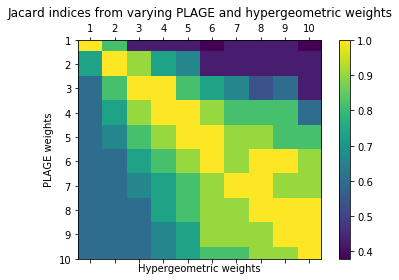

In [15]:
fig, ax = plt.subplots(1, 1)
img = ax.matshow(sim_mat)
ax.set_xticks(pals_hg_weights-1)
ax.set_xticklabels(pals_hg_weights)
ax.set_xlabel('Hypergeometric weights')
ax.set_yticks(pals_plage_weights-1)
ax.set_yticklabels(pals_plage_weights)
ax.set_ylabel('PLAGE weights')
fig.colorbar(img)
plt.title('Jacard indices from varying PLAGE and hypergeometric weights', y=1.08)
plt.tight_layout()
plt.savefig('similarity.eps', dpi=300)

### Compare ORA vs PALS

Set up some parameters

In [16]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weight = 1
pals_hg_weight = 0
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
n_sample = 4
case = 'Stage1'
control = 'Control'
N = 20
threshold = SIGNIFICANT_THRESHOLD

Run PALS and ORA on the full data

In [17]:
pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
full_df_ora = pals.get_ora_df()
full_df_pals = pals.get_pathway_df(resample=pals_resample)
full_df_ora.sort_values(significant_column, inplace=True)
full_df_pals.sort_values(significant_column, inplace=True)

2019-12-17 14:53:13.081 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-17 14:53:13.087 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:385 - Setting the zero intensity values in the dataframe
2019-12-17 14:53:28.538 | DEBUG    | pals.pathway_analysis:get_ora_df:109 - Correcting for multiple t-tests
2019-12-17 14:53:28.545 | DEBUG    | pals.pathway_analysis:_calculate_coverage_df:471 - Calculating dataset formula coverage
2019-12-17 14:53:28.553 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:385 - Setting the zero intensity values in the dataframe
2019-12-17 14:53:28.637 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:366 - Scaling the data across the sample: zero mean and unit variance
2019-12-17 14:53:28.695 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:205 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2019-12-17 14:53:28.695 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:206 - Va

In [18]:
full_df_ora

,pw_name,Stage2/Stage1 p-value,Stage1/Control p-value,Stage2/Control p-value,PiMP_KEGG Stage2/Stage1 comb_p,PiMP_KEGG Stage1/Control comb_p,PiMP_KEGG Stage2/Control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,,,,,
map00930,Caprolactam degradation,0.020308,2.629191e-07,1.609888e-05,0.209176,0.000054,0.001105,19,12,63.16
map00622,Xylene degradation,0.037897,2.634549e-05,3.445397e-07,0.281996,0.002714,0.000071,24,10,41.67
map00460,Cyanoamino acid metabolism,0.007631,1.323420e-04,3.541736e-02,0.120925,0.007149,0.455999,40,23,57.50
map00642,Ethylbenzene degradation,0.361732,1.388231e-04,2.024196e-06,0.856515,0.007149,0.000208,14,7,50.00
map00061,Fatty acid biosynthesis,0.274202,4.188068e-04,3.087144e-03,0.724174,0.017255,0.057814,10,5,50.00
...,...,...,...,...,...,...,...,...,...,...
map00830,Retinol metabolism,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,9,1,11.11
map04122,Sulfur relay system,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,8,1,12.50
map07015,Local analgesics,0.147941,1.000000e+00,1.000000e+00,0.555773,1.000000,1.000000,5,1,20.00


In [19]:
full_df_pals

,pw_name,Stage2/Stage1 p-value,Stage1/Control p-value,Stage2/Control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,PiMP_KEGG Stage2/Stage1 comb_p,PiMP_KEGG Stage1/Control comb_p,PiMP_KEGG Stage2/Control comb_p
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000,0.0,1.000000,5,1,20.00,1.304249e-01,0.54,10.80,0.000000,0.0,1.000000
map04961,Endocrine and other factor-regulated calcium r...,0.000000,0.0,1.000000,7,1,14.29,2.112254e-01,0.76,10.86,0.000000,0.0,1.000000
map00930,Caprolactam degradation,0.999997,0.0,0.000009,19,12,63.16,8.358982e-09,2.05,10.79,0.999997,0.0,0.000009
map00902,Monoterpenoid biosynthesis,0.133583,0.0,0.000442,19,5,26.32,1.585074e-02,2.05,10.79,0.133583,0.0,0.000442
map00903,Limonene and pinene degradation,0.065388,0.0,0.000093,17,5,29.41,9.142314e-03,1.84,10.82,0.065388,0.0,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
map00564,Glycerophospholipid metabolism,0.999999,1.0,1.000000,23,4,17.39,1.092647e-01,2.49,10.83,0.999999,1.0,1.000000
map00121,Secondary bile acid biosynthesis,0.999545,1.0,0.997057,9,2,22.22,8.451166e-02,0.97,10.78,0.999545,1.0,0.997057
map04672,Intestinal immune network for IgA production,1.000000,1.0,1.000000,1,1,100.00,1.165566e-02,0.11,11.00,1.000000,1.0,1.000000
map00254,Aflatoxin biosynthesis,1.000000,1.0,1.000000,24,2,8.33,5.176321e-01,2.59,10.79,1.000000,1.0,1.000000


## Resampling experiment

Now try with a resampled data source. Here we will randomly resample columns from the original full data, and observe this changes the pathway ranking results.

In [20]:
ds_plasma_resampled = ds_plasma.resample(n_sample, case=case, control=control, axis=1)
pals = PALS(ds_plasma_resampled, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
partial_df_ora = pals.get_ora_df()
partial_df_pals = pals.get_pathway_df(resample=pals_resample)
partial_df_ora.sort_values(significant_column, inplace=True)
partial_df_pals.sort_values(significant_column, inplace=True)

2019-12-17 14:53:34.808 | DEBUG    | pals.feature_extraction:__init__:40 - Loading C:\Users\joewa\Work\git\PALS\pals\data\PiMP_KEGG.json.zip
2019-12-17 14:53:34.830 | DEBUG    | pals.feature_extraction:__init__:92 - Mapping pathway to unique ids
2019-12-17 14:53:34.835 | DEBUG    | pals.feature_extraction:__init__:106 - Creating dataset to pathway mapping
2019-12-17 14:53:35.194 | DEBUG    | pals.feature_extraction:__init__:134 - Computing unique id counts
2019-12-17 14:53:35.203 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-17 14:53:35.205 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:385 - Setting the zero intensity values in the dataframe
2019-12-17 14:53:38.514 | DEBUG    | pals.pathway_analysis:get_ora_df:109 - Correcting for multiple t-tests
2019-12-17 14:53:38.518 | DEBUG    | pals.pathway_analysis:_calculate_coverage_df:471 - Calculating dataset formula coverage
2019-12-17 14:53:38.521 | DEBUG    | pals.pathway_analysis:_change_zero_peak

In [21]:
ora_full = _select_significant_entries(full_df_ora, significant_column, N, threshold)
ora_partial = _select_significant_entries(partial_df_ora, significant_column, N, threshold)
_compute_prec_rec_f1(ora_full, ora_partial)

(3, 0, 6, 1.0, 0.3333333333333333, 0.5)

In [22]:
ora_full

,pw_name,p_value
mapids,,
map00930,Caprolactam degradation,0.000054
map00622,Xylene degradation,0.002714
map00460,Cyanoamino acid metabolism,0.007149
map00642,Ethylbenzene degradation,0.007149
map00061,Fatty acid biosynthesis,0.017255
map00643,Styrene degradation,0.017939
ingenza00007,IG-Amino-acid Biosynthesis 2,0.029064
map00360,Phenylalanine metabolism,0.029064
map00350,Tyrosine metabolism,0.029064


In [23]:
ora_partial

,pw_name,p_value
mapids,,
map00930,Caprolactam degradation,0.001792
map00061,Fatty acid biosynthesis,0.011383
map00642,Ethylbenzene degradation,0.033163


In [24]:
pals_full = _select_significant_entries(full_df_pals, significant_column, N, threshold)
pals_partial = _select_significant_entries(partial_df_pals, significant_column, N, threshold)
_compute_prec_rec_f1(pals_full, pals_partial)

(3, 0, 17, 1.0, 0.15, 0.2608695652173913)

In [25]:
pals_full

,pw_name,p_value
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000e+00
map04961,Endocrine and other factor-regulated calcium r...,0.000000e+00
map00930,Caprolactam degradation,0.000000e+00
map00902,Monoterpenoid biosynthesis,0.000000e+00
map00903,Limonene and pinene degradation,0.000000e+00
map00981,Insect hormone biosynthesis,2.375765e-31
map04913,Ovarian steroidogenesis,4.273021e-16
map05215,Prostate cancer,4.377533e-15
map00626,Naphthalene degradation,4.892056e-07
map00622,Xylene degradation,6.136673e-07


In [26]:
pals_partial

,pw_name,p_value
map07226,"Progesterone, androgen and estrogen receptor a...",0.006807
map04961,Endocrine and other factor-regulated calcium r...,0.006807
map00981,Insect hormone biosynthesis,0.032808
